# Spotify Music and Artists Recommendation 

People struggle to find new music which caters to their unique taste.

Using the spotify dataset which is a dataset of songs, I created a system to recommend personalised music based on each user's music taste.

In [2]:

import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [44]:
spotifydata = pd.read_csv("data.csv")
artist_data = pd.read_csv('data_by_artist.csv')

Index(['mode', 'count', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'popularity', 'key'],
      dtype='object')


## Correlation between various features of the dataset 

In [6]:
spotifydata.corr().style.background_gradient(cmap="YlOrBr")

<AxesSubplot:>

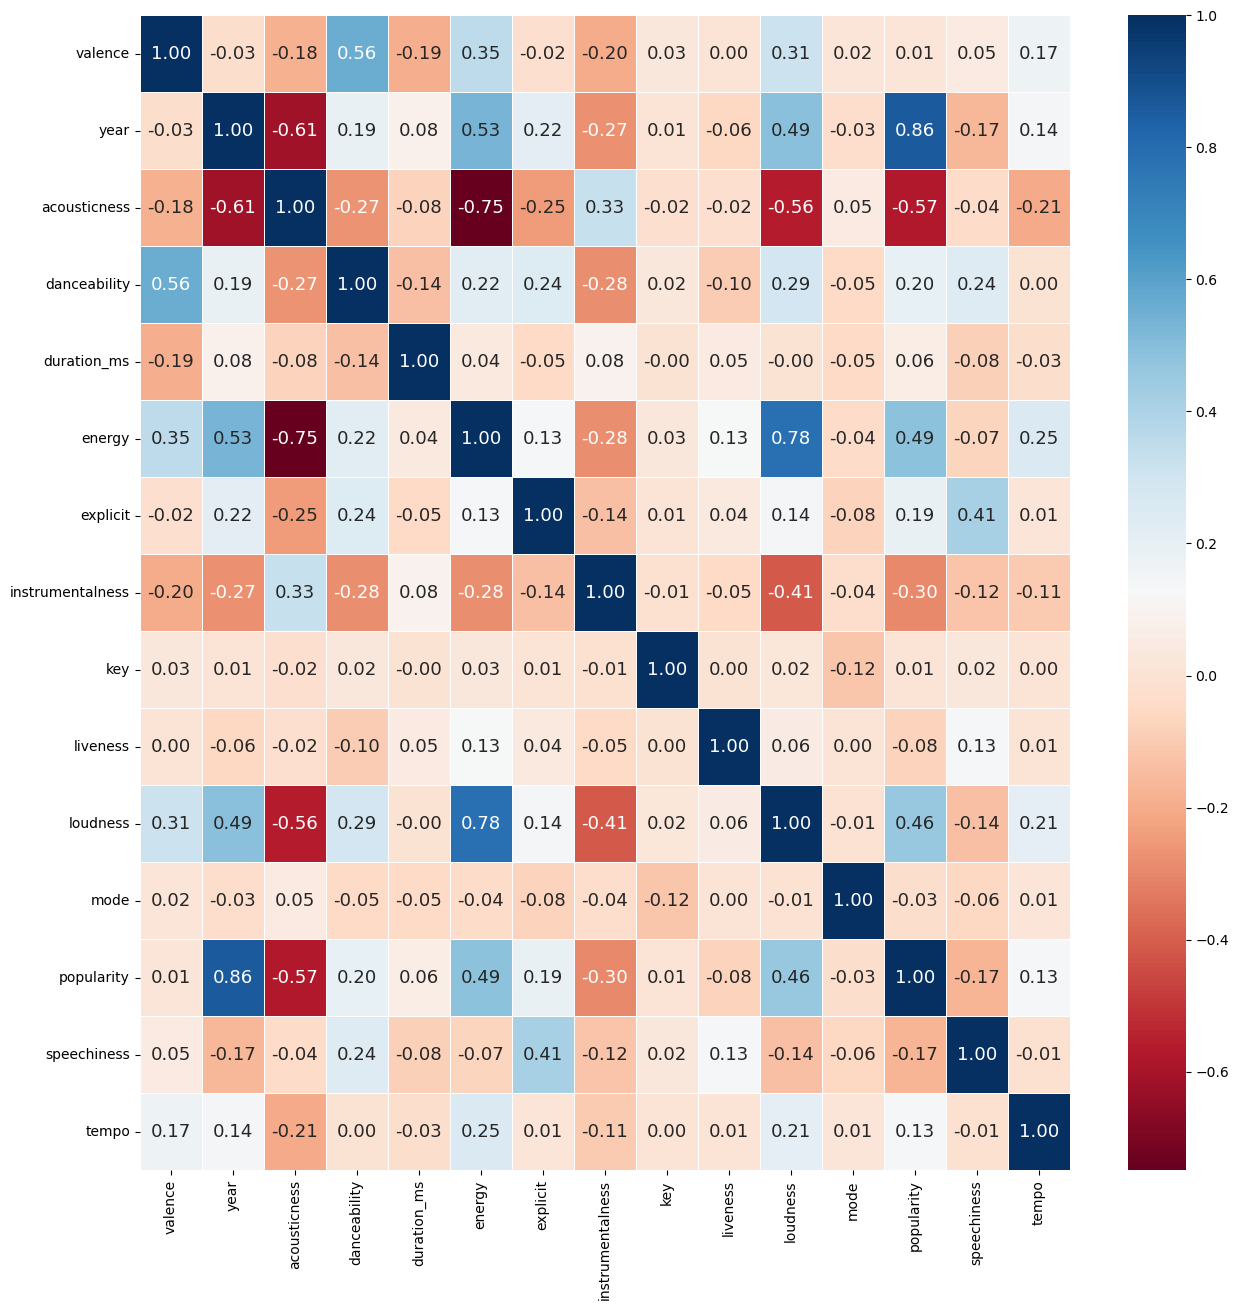

In [5]:
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(spotifydata.corr(), linewidths= 0.5, annot = True, fmt = ".2f", annot_kws = {"size": 13}, cmap = "RdBu")

## Most Popular Songs each year (2000 - 2020)

In [58]:
popularity = pd.DataFrame()
for year in range(2000, 2020):
    year_data = spotifydata.loc[spotifydata['year'] == year]
    pop = (year_data['popularity'].max())
    popularity = popularity.append(year_data.loc[year_data['popularity'] == pop].iloc[0])
fig = px.bar(popularity, x='name', y='popularity', color='year',
                labels={
                     "name": "Song",
                     "popularity": "Popularity",
                     "year": "Year"
                    })
fig.show()

## KMeans Model

We cluster the songs based on their features using KMeans

First we identify the ideal number of clusters by using the elbow method on plotting the within Cluster Sum of Squares 
against the number of clusters (2 - 25)

In [4]:
min_clust = 2
max_clust = 25


X = spotifydata.select_dtypes(np.number)
number_cols = list(X.columns)

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust)
    kmeans.fit(X)
    within_ss.append(kmeans.inertia_)


6


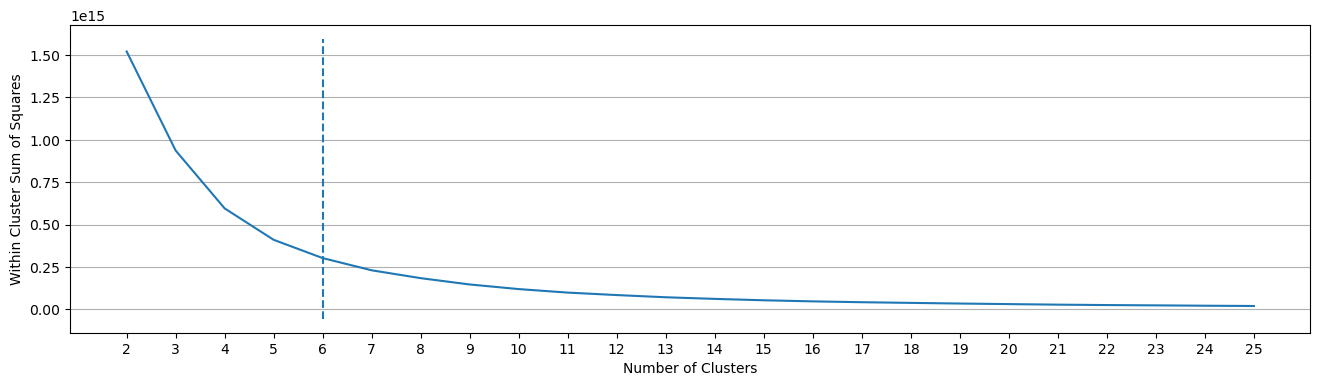

In [5]:
x = range(1, len(within_ss)+1)

from kneed import KneeLocator
kn = KneeLocator(x, within_ss, curve='convex', direction='decreasing')
print(kn.knee)

# Plot Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

## Song clustering
We find the elbow point of convergence to be 6, thus we take the number of clusters to be 6 in our KMeans model

In [6]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=6, 
                                   verbose=False))
                                 ], verbose=False)
          
X = spotifydata.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
spotifydata['cluster_label'] = song_cluster_labels

We can visualise the clusters of songs by reducing the dimensions to two dimensional data using PCA and plotting the values

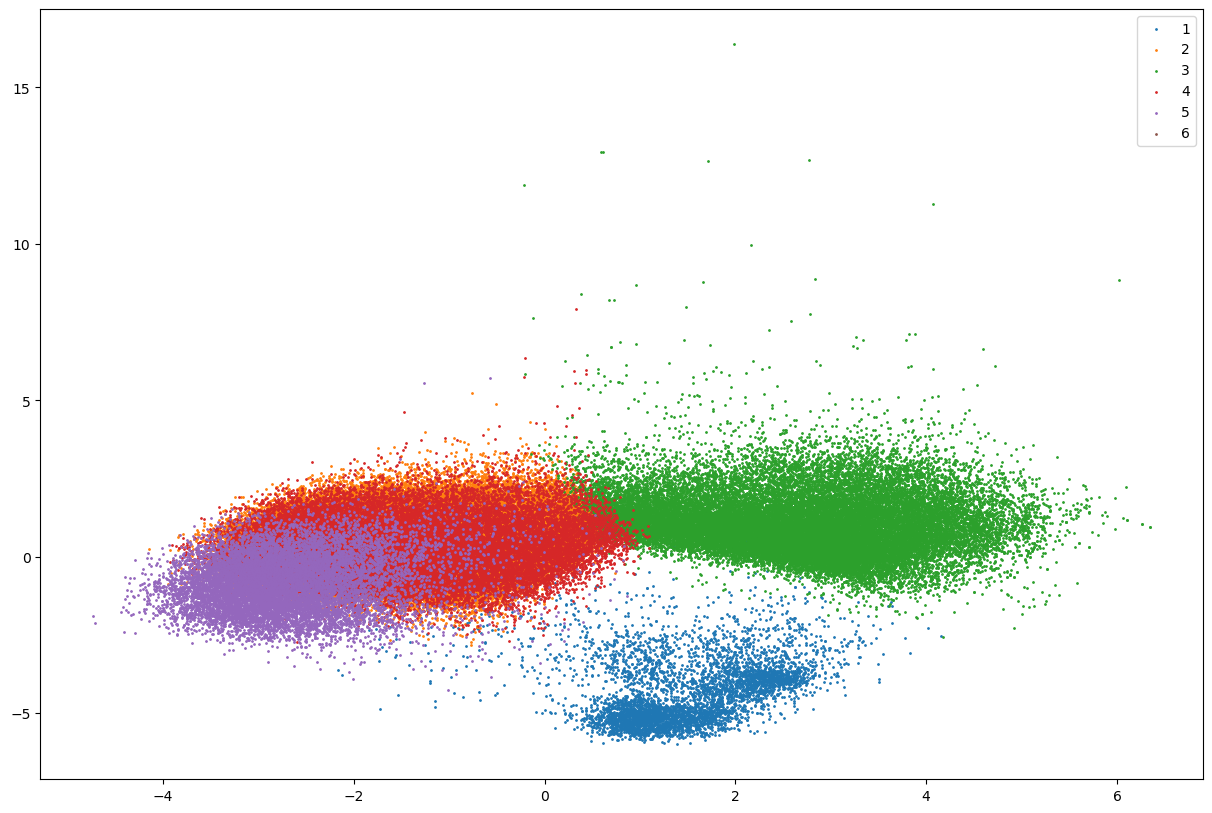

In [7]:
from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
song_embedding =pd.DataFrame(song_embedding)
song_embedding['cluster'] = spotifydata['cluster_label']

plt.figure(figsize=(15, 10))
for i in range(1, 7):
    plt.scatter(song_embedding.loc[song_embedding['cluster'] == i][0] , song_embedding.loc[song_embedding['cluster'] == i][1], label = i,
     s = 1)
plt.legend() 
plt.show()



# Artist Clustering

In [8]:
artist_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=6, 
                                   verbose=False))
                                 ], verbose=False)
                                
Y = artist_data.select_dtypes(np.number)
number_cols = list(Y.columns)
del number_cols[:2]
print(number_cols)
Y = artist_data[number_cols]
artist_cluster_pipeline.fit(Y)
artist_cluster_labels = artist_cluster_pipeline.predict(Y)
artist_data['cluster_label'] = artist_cluster_labels

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']


In [9]:

from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
artist_embedding = pca_pipeline.fit_transform(Y)
projection = pd.DataFrame(columns=['x', 'y'], data=artist_embedding)
projection['artist'] = artist_data['artists']
projection['cluster'] = artist_data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'artist'])
fig.show()

# Spotify Recommendation System

We can now recommend music that caters to each individuals unique music taste by analysing the features of the songs from the user's playlist

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="3e1d863594734f86a253c019229aa680",
                                                           client_secret="3ccd28e709bf4f508b5937da0bbe4557"))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [11]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        
def get_mean_vector(song_list, spotify_data, cols):
    
    song_vectors = []
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict

In [12]:
def recommend_songs( song_list, spotify_data, n_songs=10):
    song_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
    'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list, spotify_data, song_cols)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[song_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [13]:
def recommend_artists(song_list, spotify_data, n_songs=10):
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    artist_columns =  ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
    'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']
    song_center = get_mean_vector(song_list, spotify_data, artist_columns)
    scaler = artist_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(artist_data[artist_columns])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_artists = artist_data.iloc[index]
    return list(rec_artists['artists'])

# Recommendation
We can see that the songs getting recommended are of similar type to that given as input. The system helps the user find new music which caters to his/her taste.

In [14]:
song = recommend_songs([{'name': 'Drag Me Down', 'year': 2015},
                {'name': 'Payphone', 'year': 2012},
                {'name': 'Blank Space', 'year': 2014},], spotifydata)

print('Recommended songs\n')
for x in song:
    print(x['name'], x['year'], x['artists'])

Recommended songs

24K Magic 2016 ['Bruno Mars']
Take You Dancing 2020 ['Jason Derulo']
Crazy Over You 2020 ['BLACKPINK']
Sweet but Psycho 2020 ['Ava Max']
MORE & MORE 2020 ['TWICE']
We Found Love 2011 ['Rihanna', 'Calvin Harris']
Lonely (with Jonas Brothers) 2020 ['Diplo', 'Jonas Brothers']
We Found Love 2011 ['Rihanna', 'Calvin Harris']
One Thing 2012 ['One Direction']
Body 2017 ['Loud Luxury', 'Brando']


In [15]:
artist = recommend_artists([{'name': 'Mask Off', 'year': 2017},
                {'name': 'HUMBLE.', 'year': 2017},
                {'name': 'MIDDLE CHILD', 'year': 2019}
                ], spotifydata)
print('Recommended artists\n')
for x in artist:
    print(x)

Recommended artists

Murda Beatz
CHASE B
Lil Tjay
Metro Boomin
Smokepurpp
King Von
Saudi
Lil Baby
Rod Wave
21 Savage
